# Code required to generate Figure 3. 
Note that the code in 01_Prepare Data should be run before this. This figure will differ slightly from the one presented in the paper as it is run using the sample data (due to file size constraints) uploaded to the online repository. The full raw data is available on request from the authors.

In [23]:
import pandas as pd
import numpy as np
from scipy.interpolate import interpn, interp1d, RegularGridInterpolator
from scipy.stats import ttest_1samp, pearsonr, spearmanr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.transforms import ScaledTranslation, blended_transform_factory
import seaborn as sns

from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import gmean
import scienceplots

plt.style.use("high-contrast")
colours = ["C0", "C1", "C2"]

import statsmodels.api as sm
import statsmodels.formula.api as smf

import patato as pat

from paiskintonetools import setup_matplotlib, get_example_scan_of_type
from paiskintonetools.stats import p_formatter, loess_bootstrap, LinearRegDiagnostic
from paiskintonetools.zoomeffect import zoom_effect02

from pathlib import Path

setup_matplotlib(dpi=300)
plt.rcParams["figure.constrained_layout.use"] = False

custom_transform = lambda x, y=0: ScaledTranslation(-x / 4, -y / 4, fig.dpi_scale_trans)
from figure3_tools import make_figure_6_plot


def get_lineplot(rec, roi, delta=0.001):
    xs = rec.da.coords["z"].values
    ys = rec.da.coords["x"].values
    d = np.linspace(-delta, delta, 100)

    x0, y0 = np.array(roi.get_polygon().centroid.xy).flatten()
    points = np.stack([np.ones_like(d) * x0, d + y0]).T
    return d * 1000, interpn((xs, ys), np.squeeze(rec.raw_data).T, points), points

In [24]:
import matplotlib.pyplot as plt

from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxConnector,
    BboxConnectorPatch,
    BboxPatch,
)


def connect_bbox(
    bbox1, bbox2, loc1a, loc2a, loc1b, loc2b, prop_lines, prop_patches=None
):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1,
        bbox2,
        loc1=loc1a,
        loc2=loc2a,
        clip_on=False,
        in_layout=False,
        **prop_lines
    )
    c2 = BboxConnector(
        bbox1,
        bbox2,
        loc1=loc1b,
        loc2=loc2b,
        clip_on=False,
        in_layout=False,
        **prop_lines
    )

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(
        bbox1,
        bbox2,
        loc1a=loc1a,
        loc2a=loc2a,
        loc1b=loc1b,
        loc2b=loc2b,
        clip_on=False,
        **prop_patches
    )

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main Axes
    ax1 : the zoomed Axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(tt, ax2.transData)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1,
        mybbox2,
        loc1a=3,
        loc2a=3,
        loc1b=2,
        loc2b=2,
        prop_lines=kwargs,
        prop_patches=prop_patches,
    )

    # ax1.add_patch(bbox_patch1)
    # ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    # ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

In [25]:
def agg_function(x, npf=np.nanmean):
    if np.issubdtype(x.dtype, np.number):
        return npf(x)
    elif hasattr(x.iloc[0], "dtype"):
        # Assume that this is a numpy array.
        return npf(np.stack(x), axis=0)
    else:
        return x.iloc[0]

In [26]:
def fit_fluence_model(data_full, y="so2_mean", ita_threshold=10):
    data = data_full[data_full["ITA"] > ita_threshold]

    df = pd.read_csv("../Fluence Correction/cali_curve.csv", index_col=0)
    df.set_index(["MVF", "WL"], inplace=True, drop=False)
    wavelengths = df.index.get_level_values(1)[:5].values
    mvf = df.index.get_level_values(0)[::5].values.copy()
    norm_grid = -np.log(df["Fluence"].values.reshape((-1, 5)))
    correction_factor_spline = RegularGridInterpolator(
        (wavelengths, mvf), norm_grid.T, method="cubic", bounds_error=False
    )

    def ita_to_mvf(ita):
        return (19.028 - 0.3692 * ita + 0.001685 * ita**2) / 100

    def get_fluence(ita, wavelength):
        mvf = ita_to_mvf(ita)
        # mvf[mvf<0.02] = 0.02
        return np.exp(-correction_factor_spline((wavelength, mvf)))

    def get_normalised_fluence(ita, wavelength):
        return get_fluence(ita, wavelength) / get_fluence(
            np.ones_like(ita) * 50, wavelength
        )

    hbspec = np.load("../Fluence Correction/HbSpec.npz")
    mua_oxy_blood = lambda wl: np.interp(
        wl, hbspec["wavelengths"], hbspec["hbo2"] * 2.303 * 150 / 64500 / 10
    )
    mua_deoxy_blood = lambda wl: np.interp(
        wl, hbspec["wavelengths"], hbspec["hb"] * 2.303 * 150 / 64500 / 10
    )

    unmixer = np.linalg.pinv([mua_oxy_blood(wavelengths), mua_deoxy_blood(wavelengths)])

    def so2_fit(so2_0, ita=None):
        if ita is None:
            ita = data["ITA"]
        ITAS, WAVELENGTHS = np.meshgrid(ita, wavelengths)
        m = mua_oxy_blood(wavelengths) * so2_0 + mua_deoxy_blood(wavelengths) * (
            1 - so2_0
        )
        fluence = get_normalised_fluence(ITAS, WAVELENGTHS)
        unmixed_results = unmixer.T @ (fluence.T * m).T
        so2_results = unmixed_results[0] / (unmixed_results[0] + unmixed_results[1])
        return so2_results

    def get_forward_model(so2_0):
        so2_results = so2_fit(so2_0)
        return np.nanmean((so2_results - data[y]) ** 2)

    from scipy.optimize import minimize_scalar

    sc = minimize_scalar(get_forward_model, [0, 1])
    ita_eval = np.linspace(np.min(data_full["ITA"]), np.max(data_full["ITA"]))
    s = so2_fit(sc.x, ita_eval)
    return sc.x, ita_eval, s, so2_fit(sc.x, data_full["ITA"])

In [27]:
import json
settings = json.load(open("../data_paths.json", "r"))
root_data_path = (Path.cwd() / "../" / settings["main_data_path"]).resolve()

In [28]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [29]:
df_data_all_points = pd.read_parquet("../01_Prepare Data/pa_values_extracted_all_meta.parquet")


def query_and_aggregate(region, roi, df_data=df_data_all_points):
    df_data = df_data.query(
        f"(Region == '{region}') and (`OtherDetail` == '') and \
               (`ROI Name` == '{roi}') and (Parallel == '')"
    )

    # First, average over the three scans taken per patient
    df_data_all = (
        df_data.groupby(["SkinID", "RunNumber", "Side", "Pigment"])
        .agg(agg_function)
        .reset_index()
    )

    # For CoV, remove Vitiligo cohort
    df_data_all_cov = df_data_all.query("`Fitzpatrick Type` != 'Vitiligo'")

    m = df_data_all_cov.groupby(["SkinID", "ITA"]).apply("mean", numeric_only=True)
    s = df_data_all_cov.groupby(["SkinID", "ITA"]).apply("std", numeric_only=True)
    cov = (s["so2_mean"] / m["so2_mean"]).reset_index()
    cov = cov.rename(columns={"so2_mean": "cov_so2"})
    cov["std_so2"] = s.reset_index()["so2_mean"]

    thb_metric = "thb_positive_mean"
    cov["cov_thb"] = (s[thb_metric] / m[thb_metric]).reset_index()[thb_metric]
    cov["std_thb"] = s.reset_index()[thb_metric]
    cov.dropna(inplace=True)

    df_data = df_data_all.groupby("SkinID").agg(agg_function).reset_index()
    return df_data, cov

In [30]:
region = "Radial Artery"
roi = "artery"
df_data, cov = query_and_aggregate(region, roi)

region = "Bicep"
roi = "muscle"
df_data_bicep, cov_bicep = query_and_aggregate(region, roi)

C:\Users\tomelse\AppData\Local\Temp\ipykernel_18216\2259437899.py:6: RuntimeWarning: Mean of empty slice
  return npf(np.stack(x), axis=0)


In [31]:
region = "Radial Artery"
roi = "skin"
df_data_skin, _ = query_and_aggregate(region, roi)

Now that the data is loaded in we can start setting up the plots

In [32]:
unmixed_to_plot = ["HbO2", "Hb"]
cmaps = {"THb": "cividis", "sO2": "magma", "HbO2": "inferno", "Hb": "viridis"}

Merge the photoacoustic data frames with the ITA dataframes:

In [33]:
itas = df_data.query("`Fitzpatrick Type` != 'Vitiligo'")[["SkinID", "ITA"]]
itas = itas.sort_values("ITA").reset_index()
index_to_use = np.linspace(0, itas.shape[0]-1, 6).astype(int)[::-1]
index_to_use[1] += 1  # Choose nicer looking scans (doesn't change conclusions!)
index_to_use[3] += 1  # Choose a nice looking scan
index_to_use[2] += 2  # Choose a nice looking scan
examples = itas[["SkinID", "ITA"]].iloc[index_to_use].reset_index(drop=True)

Now make the actual plot:

In [ ]:
fig = plt.figure(
    constrained_layout=True,
    figsize=(7, 3.25 * 5 / 4),
)

subfigs = fig.subfigures(3, height_ratios=[1.5, 1.5, 0.25])

### STEP 1: Make the Image grid ###
subfigs[0].text(0, 1, "A", va="top", ha="left", fontsize="large", fontweight="bold")
axes_images = ImageGrid(
    subfigs[0],
    (
        0.03,
        0.005,
        0.92,
        0.85,
    ),  # Rescaling from Figure 3
    nrows_ncols=(2, 6),
    axes_pad=0.05,
    share_all=True,
    label_mode="all",
    cbar_mode="edge",
    direction="row",
)

axes_images[0].set_ylim([-0.015, 0.01])
axes_images[0].set_xlim([-0.02, 0.02])
for ax in axes_images:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelbottom=False)

asb = AnchoredSizeBar(
    axes_images[-1].transData,
    0.01,
    "1 cm",
    loc="lower right",
    pad=0.1,
    borderpad=0.5,
    sep=5,
    frameon=False,
    color="white",
)
axes_images[-1].add_artist(asb)

# Add the example images to the image grid
ims = np.empty((6, len(unmixed_to_plot)), dtype=object)
for i in range(6):
    ita = examples.loc[i, "ITA"]
    title = r"$\mathdefault{ITA = " + f"{ita:.0f}" + "}$"
    axes_images[i].set_title(title, fontsize="medium", fontweight="normal")
    skin_id_to_show = examples.loc[i, "SkinID"]
    pa = pat.PAData.from_hdf5(
        get_example_scan_of_type(root_data_path / skin_id_to_show, "forearm")
    )
    if "parallel" in pa.get_scan_name():
        print(skin_id_to_show, pa.get_scan_name(), get_example_scan_of_type(root_data_path / skin_id_to_show, "forearm"))
    assert "parallel" not in pa.get_scan_name()
    rec = pa.get_scan_unmixed()["Model Based", "0"]

    xs = rec.da.coords["x"].values
    extent = rec.extent
    pa_weighting = np.exp(xs / 0.0075)
    for j, wl in enumerate(unmixed_to_plot):
        if wl == "THb":
            rec_to_show = pa.get_scan_thb()["Model Based", "0"][0, 0].raw_data * 1e4
            image = rec_to_show[50:300, 0] / pa_weighting[50:300, None]
        elif wl == "sO2":
            rec_to_show = pa.get_scan_so2()["Model Based", "0"][0, 0].raw_data
            thb_weighting = pa.get_scan_thb()["Model Based", "0"][0, 0].raw_data
            # rec_to_show[thb_weighting<np.percentile(thb_weighting, 50)] == np.nan # Hopefully remove some noise?
            image = rec_to_show[50:300, 0]
            image[image < -1] = np.nan
            image[image > 2] = np.nan
        elif wl in ["Hb", "HbO2"]:
            i_um = list(rec.ax_1_labels).index(wl)
            rec_to_show = (
                pa.get_scan_unmixed()["Model Based", "0"][0, i_um].raw_data * 1e4
            )
            image = rec_to_show[50:300, 0] / pa_weighting[50:300, None]
        else:
            raise NotImplementedError()

        ims[i, j] = axes_images[i + j * 6].imshow(
            image,
            extent=(-0.02, 0.02, -0.015, 0.01),
            origin="lower",
            cmap=cmaps[wl],
        )

for i in range(len(unmixed_to_plot)):
    # Set the clims for wavelengths
    clims = [[], []]
    for im in ims[:, i]:
        clims[0].append(im.get_clim()[0])
        clims[1].append(im.get_clim()[1])
    for im in ims[:, i]:
        im.set_clim((np.min(clims[0]), np.max(clims[1])))
    # if unmixed_to_plot[i] == "sO2":
    #     axes_images
    axes_images.cbar_axes[i].colorbar(
        ims[0, i],
        label=unmixed_to_plot[i] + " (a.u.)"
        if unmixed_to_plot[i] != "HbO2"
        else r"HbO$_\mathdefault{2}$ (a.u.)",
    )

for j, wl in enumerate(unmixed_to_plot):
    axes_images[6 * j].set_ylabel(
        wl if wl != "HbO2" else r"HbO$_\mathbf{2}$",
        fontweight="normal",
        fontsize="medium",
    )

arr = mpatches.FancyArrowPatch(
    (0.025, 0.9),
    (0.975, 0.9),
    arrowstyle="-|>,head_width=.15",
    mutation_scale=15,
    transform=subfigs[0].transSubfigure,
    clip_on=False,
    color="gray",
)
axes_images[0].add_patch(arr)
axes_images[0].annotate(
    "Increasing melanin concentration",
    (0.5, 0.8),
    xycoords=arr,
    ha="center",
    va="bottom",
    color="gray",
)

### STEP 2: Make the uncorrected unmixing plots ###
subfig_ra, subfig_ra_so2, fig_pulseox = subfigs[1].subfigures(
    1, 3, width_ratios=[1.5, 1, 1.25]
)

subfig_ra.text(0, 1, "B", va="top", ha="left", fontsize="large", fontweight="bold")
subfig_ra_so2.text(0, 1, "C", va="top", ha="left", fontsize="large", fontweight="bold")

# subfig_ra.suptitle("Radial artery", fontweight="normal", fontsize="medium")
# subfig_ra.supxlabel("ITA (degrees)", fontsize="medium", fontweight="bold")

ax_ra_thb, ax_ra_thb_extra = subfig_ra.subplots(1, 2, sharex=True)
ax_ra_thb.set_xlabel("ITA (degrees)", fontsize="medium", fontweight="bold")
ax_ra_thb_extra.set_xlabel("ITA (degrees)", fontsize="medium", fontweight="bold")
ax_ra_so2 = subfig_ra_so2.subplots()
ax_ra_so2.invert_xaxis()
ax_ra_so2.set_xlabel("ITA (degrees)", fontsize="medium", fontweight="bold")
ax_ra_thb.set_ylabel("THb")
ax_ra_so2.set_ylabel(r"sO$_\mathbf{2}^\mathbf{EST}$ (%)")

fig_pulseox.text(0, 1, "D", va="top", ha="left", fontsize="large", fontweight="bold")

from palettable.cartocolors.qualitative import Safe_4

colours_sites = [Safe_4.mpl_colors[0], Safe_4.mpl_colors[3], Safe_4.mpl_colors[2]]

y_plot = "so2_mean"
for region, ax, col in zip(
    ["forearm", "bicep", "skin"], [ax_ra_so2, ax_ra_so2, ax_ra_so2], colours_sites
):
    # Make the scatter plot
    df = (
        df_data_bicep
        if region == "bicep"
        else df_data
        if region == "forearm"
        else df_data_skin
    )
    ax.scatter(df["ITA"], df[y_plot] * 100, s=5, color=col)

    # Add smooth line of best fit.
    X, Y, Ymax, Ymin = loess_bootstrap(df["ITA"], df[y_plot], frac=0.66666, it=1)
    l = ax.plot(X, Y * 100, label="LOESS", c=col)
    ax.fill_between(X, Ymin * 100, Ymax * 100, alpha=0.3, facecolor=l[0].get_color())
    if region != "skin":
        # Add the fluence model:
        so2_0_fit, ita_eval, so2_model_plot, so2_fit_data = fit_fluence_model(
            df, ita_threshold=30
        )

        def calculate_loglik(residuals):
            # LF = (1/(sqrt(2pi)sigma))^N exp(-(xi-mu)^2/(2sigma^2))
            variance = np.mean(residuals**2)
            N = residuals.shape[0]
            return (
                -N * np.log(2 * np.pi) / 2
                - N * np.log(variance) / 2
                - np.sum(residuals**2) / (2 * variance)
            )

        def calculate_AIC(residuals, nparams):
            return 2 * nparams - 2 * calculate_loglik(residuals)

        df["Theory_so2"] = so2_fit_data

        # Calculate relative likelihood
        ita_threshold = 30  # 30
        df_aic = df[df["ITA"] > ita_threshold]
        resid_theory = df_aic[y_plot] - df_aic["Theory_so2"]
        resid_constant = df_aic[y_plot] - np.mean(df_aic[y_plot])

        resid_constant = resid_constant[~np.isnan(resid_theory)]
        resid_theory = resid_theory[~np.isnan(resid_theory)]

        print(
            region,
            np.exp(
                (calculate_AIC(resid_theory, 1) - calculate_AIC(resid_constant, 1)) / 2
            ),
        )
        print(
            region,
            "ttest",
            ttest_1samp(resid_theory, 0).pvalue,
            ttest_1samp(resid_constant, 0).pvalue,
        )
        # ita_eval = np.linspace(np.min(df["ITA"]), np.max(df["ITA"]), 100)
        # so2_model_plot = interp1d(
        #     so2_fluence_model["ita"],
        #     so2_fluence_model["so2_model"],
        #     fill_value="extrapolate",
        # )(ita_eval)
        ax.plot(
            ita_eval,
            so2_model_plot * 100,
            color=col,
            linestyle="--",
            label="Fluence model",
        )

handles, labels = ax_ra_so2.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
handles[0] = Line2D([], [], color="k", linewidth=handles[0].get_linewidth())
handles[1] = Line2D(
    [],
    [],
    color="k",
    linewidth=handles[1].get_linewidth(),
    linestyle=handles[1].get_linestyle(),
)

handles.append(
    Line2D(
        [],
        [],
        color="k",
        linewidth=handles[1].get_linewidth(),
        linestyle="dotted",
    )
)
labels.append("Linear model")

labels = ["Radial artery", "Bicep muscle", "Skin surface"] + labels
handles = [
    Line2D([], [], color=col, linewidth=handles[0].get_linewidth())
    for col in colours_sites
] + handles

subfigs[2].legend(
    handles, labels, loc="lower center", fancybox=False, ncols=len(handles)
)


# Plot the total haemoglobin values
y_plot = "thb_positive_mean"
for region, col in zip(["forearm", "bicep", "skin"], colours_sites):
    df = (
        df_data_bicep
        if region == "bicep"
        else df_data
        if region == "forearm"
        else df_data_skin
    )

    for ax in [ax_ra_thb_extra, ax_ra_thb]:
        ax.scatter(df["ITA"], df[y_plot] * 1e4, s=5, color=col)
        X, Y, Ymax, Ymin = loess_bootstrap(
            df["ITA"], df[y_plot] * 1e4, frac=0.66666, it=1
        )
        l = ax.plot(X, Y, label="LOESS", c=col)
        ax.fill_between(X, Ymin, Ymax, alpha=0.3, facecolor=l[0].get_color())

ax_ra_thb_extra.set_ylim((0.00369179985231085, 0.03812059357249596))
# Make x axes go in order of increasing skin pigment
ax_ra_thb.invert_xaxis()
zoom_effect02(ax_ra_thb_extra, ax_ra_thb, color="grey")

##### PULSE OX ANALYSIS #####
ax_pulseox = fig_pulseox.subplots()

region = "Radial Artery"
roi = "artery"
df_radial_artery_all = df_data_all_points.query(
    f"(Region == '{region}') and (`OtherDetail` == '') and \
               (`ROI Name` == '{roi}') and (Parallel == '') and (`Fitzpatrick Type` != 'Vitiligo')"
)

df_so2_all = pd.read_parquet("../Cleaned Pulse Ox/so2_ita_pulseox_all.parquet")
df_so2_all = df_so2_all[df_so2_all["Site"] == "Forearm"]
df_so2_all["RunLetter"] = df_so2_all["ScanName"].str.get(-1)
df_so2_all["RunNumber"] = df_so2_all["RepNumber"].apply(int).astype(str)
df_so2_all = df_so2_all[["SkinID", "RunNumber", "RunLetter", "Pulse Ox"]]
df_so2_all = df_radial_artery_all.merge(df_so2_all)
df_so2_all = df_so2_all[df_so2_all["Pulse Ox"] > 94]
df_so2_all["so2_median"] *= 100
df_so2_all = df_so2_all[df_so2_all["ITA"] > 10].reset_index(drop=True)

model = smf.mixedlm(
    data=df_so2_all,
    formula="Q('so2_median') ~ ITA + Q('Pulse Ox')",
    groups=df_so2_all["SkinID"],
)
mdf = model.fit()
print(mdf.summary())
oxs = [96, 98, 100]
cmap = mpl.cm.cividis
norm = mpl.colors.Normalize(vmin=min(oxs), vmax=max(oxs))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

for pox in oxs:
    df_clear = pd.DataFrame(
        {
            "ITA": np.linspace(np.min(df_data["ITA"]), np.max(df_data["ITA"])),
            "Pulse Ox": pox,
        }
    )
    df_clear["y"] = mdf.predict(df_clear)

    ax_pulseox.plot(
        df_clear["ITA"], df_clear["y"], c=sm.to_rgba(pox), linestyle="dotted"
    )
plt.colorbar(sm, ax=ax_pulseox, label=r"Pulse ox. $\mathdefault{SpO_2}$ (%)")

ax_pulseox.scatter(
    df_data["ITA"], df_data["so2_mean"] * 100, color=colours_sites[0], s=5
)
X, Y, Ymax, Ymin = loess_bootstrap(
    df_data["ITA"], df_data["so2_mean"], frac=0.66666, it=1
)
# l = ax_pulseox.plot(X, Y * 100, label="LOESS", c=colours_sites[0])
# ax_pulseox.fill_between(
#     X, Ymin * 100, Ymax * 100, alpha=0.3, facecolor=l[0].get_color()
# )

ax_pulseox.set_xlabel("ITA (degrees)")
ax_pulseox.set_ylabel(r"sO$_\mathbf{2}^\mathbf{EST}$ (%)")
ax_pulseox.invert_xaxis()

print("PA/Pulse Ox Stats:")
print(p_formatter(mdf.pvalues["Q('Pulse Ox')"]))
coeff = mdf.params["Q('Pulse Ox')"]
print(f"Coefficient = {coeff:.2f}")

# sfs = subfigs[2].subfigures(1, 3, width_ratios=[0.9, 1, 0.75])

# for sf, letter in zip(sfs, "EFG"):
#     sf.text(0, 1, letter, va="top", ha="left", fontsize="large", fontweight="bold")

# ax1, ax2, ax3 = [sf.subplots() for sf in sfs]

# make_figure_6_plot(ax1, ax2, ax3, colours=colours_sites)
# ax3.sharey(ax_ra_so2)
# ax3.text(
#     0.05,
#     0.95,
#     "Melanin fluence correction",
#     fontsize="medium",
#     va="top",
#     ha="left",
#     transform=ax3.transAxes,
# )
# ax1.text(
#     0.05,
#     0.95,
#     "Modelled ITA",
#     fontsize="medium",
#     va="top",
#     ha="left",
#     transform=ax1.transAxes,
# )
fig.savefig("figures/figure3.pdf", dpi=300)
fig.savefig("figures/figure3.svg", dpi=300)
plt.show()

In [35]:
df_data.shape

(41, 59)

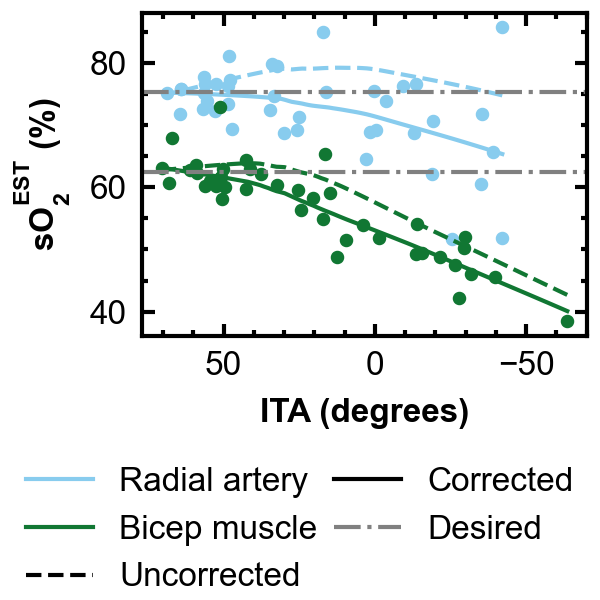

In [36]:
fig, ax = plt.subplots(figsize=(2, 2), constrained_layout=True)

colours_sites = [Safe_4.mpl_colors[0], Safe_4.mpl_colors[3], Safe_4.mpl_colors[2]]

y_plot = "corrected_so2_mean"
for region, ax, col in zip(["forearm", "bicep"], [ax, ax], colours_sites):
    # Make the scatter plot
    df = (
        df_data_bicep
        if region == "bicep"
        else df_data
        if region == "forearm"
        else df_data_skin
    )
    ax.scatter(df["ITA"], df[y_plot] * 100, s=5, color=col)

    # Add smooth line of best fit.
    X, Y, Ymax, Ymin = loess_bootstrap(
        df["ITA"], df["_".join(y_plot.split("_")[1:])], frac=0.66666, it=1
    )
    l = ax.plot(X, Y * 100, label="LOESS", c=col, linestyle="--")
    X, Y, Ymax, Ymin = loess_bootstrap(df["ITA"], df[y_plot], frac=0.66666, it=1)
    l = ax.plot(X, Y * 100, label="LOESS", c=col)
    ax.axhline(
        100 * np.mean(df[df["ITA"] > 30][y_plot]),
        color="gray",
        linestyle="-.",
        label="Desired" if region == "forearm" else None,
    )
    # ax.fill_between(X, Ymin * 100, Ymax * 100, alpha=0.3, facecolor=l[0].get_color())

ax.invert_xaxis()
ax.set_xlabel("ITA (degrees)")
ax.set_ylabel(r"$\mathdefault{sO_2^{EST}}$ (%)")

handles = []
handles.append(Line2D([], [], color=colours_sites[0]))
handles.append(Line2D([], [], color=colours_sites[1]))
handles.append(Line2D([], [], color="k", linestyle="--"))
handles.append(Line2D([], [], color="k"))
handles.append(Line2D([], [], color="gray", linestyle="-."))
fig.legend(
    handles,
    ["Radial artery", "Bicep muscle", "Uncorrected", "Corrected", "Desired"],
    loc="outside lower center",
    ncol=2,
    columnspacing=0.5,
    borderaxespad=0.1,
    borderpad=0.1,
)
fig.savefig("so2_corrected.pdf", dpi=300)
plt.show()

Supplementary figure for coefficient of variation. Note that this cannot be generated using the subset of data uploaded here (we were constrained by file size limits). The code provided to generate the figure is provided for completeness.

In [37]:
# Surpress this 
full_dataset = False # This code won't run with the sample dataset provided online. Contact authors for full dataset if interested. Code provided for completeness.
if full_dataset:
    fig = plt.figure(figsize=(4, 2), dpi=150, constrained_layout=True)
    ax1, ax2 = fig.subplots(1, 2, sharex=True)
    s = ax1.scatter(
        cov["ITA"], cov["cov_so2"] * 100, s=5, label=r"sO$_\mathbf{2}^\mathbf{EST}$"
    )
    x, y, up, lo = loess_bootstrap(cov["ITA"].values, cov["cov_so2"].values * 100)
    ax1.plot(x, y, c=s.get_facecolor())
    ax1.fill_between(x, lo, up, alpha=0.2, color=s.get_facecolor())
    pr = spearmanr(cov["ITA"], cov["cov_so2"])
    ax1.text(65, 50, p_formatter(pr.pvalue) + f", r = {pr.statistic:.2f}", c="C0")
    print(pr.statistic)
    s = ax1.scatter(cov["ITA"], cov["cov_thb"] * 100, s=5, label="THb")
    x, y, up, lo = loess_bootstrap(cov["ITA"].values, cov["cov_thb"].values * 100)
    ax1.plot(x, y, c=s.get_facecolor())
    ax1.fill_between(x, lo, up, alpha=0.2, color=s.get_facecolor())
    pr = spearmanr(cov["ITA"], cov["cov_thb"])
    ax1.text(65, 44, p_formatter(pr.pvalue) + f", r = {pr.statistic:.2f}", c="C1")
    print(pr.statistic)
    ax1.invert_xaxis()
    ax1.set_ylabel("Coefficient of variation (%)")
    # ax1.set_xlabel("ITA (degrees)")
    # ax2.set_xlabel("ITA (degrees)")
    
    s = ax2.scatter(
        cov_bicep["ITA"],
        cov_bicep["cov_so2"] * 100,
        s=5,
        label=r"sO$_\mathbf{2}^\mathbf{EST}$ (%)",
    )
    x, y, up, lo = loess_bootstrap(
        cov_bicep["ITA"].values, cov_bicep["cov_so2"].values * 100
    )
    ax2.plot(x, y, c=s.get_facecolor())
    ax2.fill_between(x, lo, up, alpha=0.2, color=s.get_facecolor())
    
    pr = spearmanr(cov_bicep["ITA"], cov_bicep["cov_so2"])
    ax2.text(
        65, 60 + 5 * 8 / 5.3, p_formatter(pr.pvalue) + f", r = {pr.statistic:.2f}", c="C0"
    )
    print(pr.statistic)
    s = ax2.scatter(cov_bicep["ITA"], cov_bicep["cov_thb"] * 100, s=5, label="THb")
    
    x, y, up, lo = loess_bootstrap(
        cov_bicep["ITA"].values, cov_bicep["cov_thb"].values * 100
    )
    ax2.plot(x, y, c=s.get_facecolor())
    ax2.fill_between(x, lo, up, alpha=0.2, color=s.get_facecolor())
    pr = spearmanr(cov_bicep["ITA"], cov_bicep["cov_thb"])
    ax2.text(65, 60, p_formatter(pr.pvalue) + f", r = {pr.statistic:.2f}", c="C1")
    print(pr.statistic)
    
    ax1.set_title("Radial artery", fontweight="normal", fontsize="medium")
    ax2.set_title("Bicep muscle", fontweight="normal", fontsize="medium")
    
    fig.supxlabel("ITA (degrees)", fontsize="medium", fontweight="bold")
    
    fig.legend(
        *ax1.get_legend_handles_labels(),
        loc="outside center right",
        # ncols=2,
        borderpad=0,
        fancybox=False,
        borderaxespad=0,
    )
    plt.savefig("figures/cov_um_supp.pdf", dpi=300)
    plt.savefig("figures/cov_um_supp.svg", dpi=300)
    plt.show()

In [38]:
if full_dataset:
    ## i = 0
    for df_plot in [cov, cov_bicep]:
        df_plot["Fitzpatrick Group"] = df_plot["ITA"] > np.median(df_plot["ITA"])
        for fp, g in df_plot.iloc[2:].groupby("Fitzpatrick Group"):
            print(
                "THb",
                "Bicep" if i == 1 else "RA",
                "ITA > median" if fp else "ITA < median",
                "COV mean",
                100 * np.nanmean(np.stack(g["cov_thb"])),
            )
            print(
                "sO2",
                "Bicep" if i == 1 else "RA",
                "ITA > median" if fp else "ITA < median",
                "COV mean",
                100 * np.nanmean(np.stack(g["cov_so2"])),
            )
        i += 1